In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras import Model, Sequential
from keras.layers import Input, Dense, Flatten, Embedding, Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

import talos
from talos import Predict

import os.path as path

Using TensorFlow backend.


## Carichiamo i dati

In [2]:
PATH = path.abspath("")+'/dataset/bert/'

train_data = pd.read_csv(PATH+'train.csv')
train_vectors = np.load(PATH+'bert_train_vectors.npy')
test_vectors = pd.read_csv(PATH+'bert_test_vectors.csv', header=None)
test_labels = pd.read_csv(PATH+'bert_test_labels.csv', header=None)

list_classes = list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_labels = train_data[list_classes].values

In [3]:
test_vectors.shape

(6243, 768)

### Split train data in train and validation 

In [4]:
x_train, x_val, y_train, y_val = train_test_split(train_vectors, train_labels, test_size=0.2, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(127656, 768)
(127656, 6)
(31915, 768)
(31915, 6)


### Definiamo le metriche custom da utilizzare durante la Fit

In [5]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fmeasure(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Definiamo le funzioni per visualizzare i plot che mostrano l'andamento dell'apprendimento

In [6]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('F1measure')
    plt.plot(x_plot, network_history.history['fmeasure'])
    plt.plot(x_plot, network_history.history['val_fmeasure'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

### Ok, a questo punto possiamo iniziare a OTTIMIZZARE!
### Dobbiamo definire la rete come una funzione black box: la funzione prende in input i dati e gli iperparametri da ottimizare e restituisce la history e il modello stesso

In [7]:
import talos
from keras import optimizers
# define the model function:
def toxic_clf(x_train, y_train, x_val, y_val, params):
    sequence_input = Input(shape=(x_train.shape[1],), name='input')
    layer = Dense(params['first_hidden'], activation="relu", name='hidden_1')(sequence_input)
    layer = Dropout(0.3)(layer)
    layer = Dense(params['second_hidden'], activation="relu", name='hidden_2')(layer)
    layer = Dense(params['third_hidden'], activation="relu", name='hidden_3')(layer)
    output = Dense(6, activation="sigmoid", name='output')(layer)
    model = Model(sequence_input, output)
    
    # Optimizer
    opt = optimizers.Adam(learning_rate=0.005, amsgrad=True)

    # Monitor on learning rate
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                                patience=2, 
                                                verbose=1, 
                                                mode='min',
                                                factor=0.5, 
                                                min_lr=0.00001)

    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy', fmeasure])
    
    nepochs = params['round_epochs']
    batch = params['batch_size']
    history = model.fit(x_train, y_train, epochs = nepochs, batch_size = batch, 
                        validation_data = (x_val, y_val), callbacks=[learning_rate_reduction])
    
    return history, model

### Definiamo prima di tutto un insieme di iperparametri indicativo secondo le nostre esperienze con questo dataset
### Dopo una esecuzione con un budget limitato sarà possibile analizzare i risultati per ridurre lo spazio di ricerca.

In [8]:
# Define the params dict
params = {'first_hidden':[200, 400, 560, 768, 800],
     'batch_size': [32, 64, 128],
     'round_epochs': [12, 15, 18],
     'second_hidden': [100, 200, 300],
     'third_hidden': [20, 32, 50]}

### Procediamo con un modello random forest con budget 4

In [9]:
# Define the scan
scan_object = talos.Scan(x=x_train,
                         y=y_train,
                         x_val=x_val,
                         y_val=y_val,
                         params=params,
                         reduction_method='forrest',
                         reduction_metric='val_fmeasure',
                         performance_target=['val_fmeasure', 0.8, False],
                         model=toxic_clf,
                         experiment_name='toxic_comments',
                         fraction_limit=.01)

  0%|          | 0/4 [00:00<?, ?it/s]

Train on 127656 samples, validate on 31915 samples
Epoch 1/18
127656/127656 [==============================] - 7s 53us/step - loss: 0.0618 - accuracy: 0.9771 - fmeasure: 0.6227 - val_loss: 0.0556 - val_accuracy: 0.9780 - val_fmeasure: 0.6083
Epoch 2/18
127656/127656 [==============================] - 7s 53us/step - loss: 0.0546 - accuracy: 0.9794 - fmeasure: 0.6640 - val_loss: 0.0536 - val_accuracy: 0.9794 - val_fmeasure: 0.6445
Epoch 3/18
127656/127656 [==============================] - 7s 53us/step - loss: 0.0523 - accuracy: 0.9802 - fmeasure: 0.6791 - val_loss: 0.0519 - val_accuracy: 0.9802 - val_fmeasure: 0.6873
Epoch 4/18
127656/127656 [==============================] - 6s 51us/step - loss: 0.0512 - accuracy: 0.9804 - fmeasure: 0.6867 - val_loss: 0.0560 - val_accuracy: 0.9789 - val_fmeasure: 0.6301
Epoch 5/18
127656/127656 [==============================] - 6s 50us/step - loss: 0.0502 - accuracy: 0.9807 - fmeasure: 0.6919 - val_loss: 0.0515 - val_accuracy: 0.9804 - val_fmeasure: 0

 25%|██▌       | 1/4 [01:59<05:59, 119.81s/it]

Train on 127656 samples, validate on 31915 samples
Epoch 1/12
127656/127656 [==============================] - 23s 181us/step - loss: 0.0624 - accuracy: 0.9773 - fmeasure: 0.5479 - val_loss: 0.0546 - val_accuracy: 0.9793 - val_fmeasure: 0.6007
Epoch 2/12
127656/127656 [==============================] - 22s 176us/step - loss: 0.0560 - accuracy: 0.9792 - fmeasure: 0.5843 - val_loss: 0.0556 - val_accuracy: 0.9794 - val_fmeasure: 0.5827
Epoch 3/12
127656/127656 [==============================] - 23s 181us/step - loss: 0.0539 - accuracy: 0.9798 - fmeasure: 0.5957 - val_loss: 0.0538 - val_accuracy: 0.9794 - val_fmeasure: 0.5908
Epoch 4/12
127656/127656 [==============================] - 23s 178us/step - loss: 0.0527 - accuracy: 0.9801 - fmeasure: 0.6021 - val_loss: 0.0521 - val_accuracy: 0.9804 - val_fmeasure: 0.6241
Epoch 5/12
127656/127656 [==============================] - 23s 180us/step - loss: 0.0517 - accuracy: 0.9804 - fmeasure: 0.6164 - val_loss: 0.0522 - val_accuracy: 0.9799 - val_f

 50%|█████     | 2/4 [06:37<05:34, 167.04s/it]

Train on 127656 samples, validate on 31915 samples
Epoch 1/18
127656/127656 [==============================] - 21s 164us/step - loss: 0.0624 - accuracy: 0.9774 - fmeasure: 0.6094 - val_loss: 0.0579 - val_accuracy: 0.9775 - val_fmeasure: 0.5564
Epoch 2/18
127656/127656 [==============================] - 20s 157us/step - loss: 0.0556 - accuracy: 0.9793 - fmeasure: 0.6384 - val_loss: 0.0549 - val_accuracy: 0.9791 - val_fmeasure: 0.6703
Epoch 3/18
127656/127656 [==============================] - 20s 154us/step - loss: 0.0537 - accuracy: 0.9800 - fmeasure: 0.6544 - val_loss: 0.0522 - val_accuracy: 0.9802 - val_fmeasure: 0.6662
Epoch 4/18
127656/127656 [==============================] - 20s 154us/step - loss: 0.0524 - accuracy: 0.9802 - fmeasure: 0.6605 - val_loss: 0.0539 - val_accuracy: 0.9798 - val_fmeasure: 0.6537
Epoch 5/18
127656/127656 [==============================] - 20s 155us/step - loss: 0.0512 - accuracy: 0.9805 - fmeasure: 0.6721 - val_loss: 0.0518 - val_accuracy: 0.9803 - val_f

 75%|███████▌  | 3/4 [12:41<03:46, 226.41s/it]


Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Train on 127656 samples, validate on 31915 samples
Epoch 1/15
127656/127656 [==============================] - 9s 73us/step - loss: 0.0623 - accuracy: 0.9772 - fmeasure: 0.6188 - val_loss: 0.0554 - val_accuracy: 0.9788 - val_fmeasure: 0.6360
Epoch 2/15
127656/127656 [==============================] - 9s 69us/step - loss: 0.0551 - accuracy: 0.9793 - fmeasure: 0.6621 - val_loss: 0.0536 - val_accuracy: 0.9792 - val_fmeasure: 0.6426
Epoch 3/15
127656/127656 [==============================] - 9s 70us/step - loss: 0.0527 - accuracy: 0.9799 - fmeasure: 0.6748 - val_loss: 0.0527 - val_accuracy: 0.9793 - val_fmeasure: 0.6870
Epoch 4/15
127656/127656 [==============================] - 9s 68us/step - loss: 0.0514 - accuracy: 0.9805 - fmeasure: 0.6852 - val_loss: 0.0512 - val_accuracy: 0.9805 - val_fmeasure: 0.6905
Epoch 5/15
127656/127656 [==============================] - 9s 70us/step - loss: 0.0502 - accuracy: 0.9

100%|██████████| 4/4 [14:56<00:00, 224.13s/it]


Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


### Dopo la scan osserviamo i risultati

In [10]:
# accessing the results data frame
print('Check values:\n')
print(scan_object.data.head())

# accessing epoch entropy values for each round
print('\nEntropy:\n')
print(scan_object.learning_entropy)

# access the summary details
print('\nSummary:\n')
print(scan_object.details)

Check values:

   round_epochs  val_loss  val_accuracy  val_fmeasure      loss  accuracy  \
0            18  0.051027      0.981127      0.714253  0.036411  0.985661   
1            12  0.050806      0.980626      0.647561  0.042782  0.983317   
2            18  0.051399      0.980971      0.688748  0.038085  0.985073   
3            15  0.051183      0.980861      0.703184  0.037709  0.985068   

   fmeasure        lr  batch_size  first_hidden  round_epochs  second_hidden  \
0  0.781102  0.000156         128           400            18            100   
1  0.670621  0.001250          32           560            12            100   
2  0.757332  0.000312          64           768            18            300   
3  0.771434  0.000625         128           560            15            200   

   third_hidden  
0            32  
1            50  
2            32  
3            50  

Entropy:

       loss  accuracy  fmeasure        lr
0  2.878770  2.890369  2.888487  2.602597
1  2.479414  

In [11]:
# Analyze scan object
analyze_object = talos.Analyze(scan_object)
# Results
analyze_object.data

,round_epochs,val_loss,val_accuracy,val_fmeasure,loss,accuracy,fmeasure,lr,batch_size,first_hidden,round_epochs,second_hidden,third_hidden
0,18,0.051027,0.981127,0.714253,0.036411,0.985661,0.781102,0.000156,128,400,18,100,32
1,12,0.050806,0.980626,0.647561,0.042782,0.983317,0.670621,0.001250,32,560,12,100,50
2,18,0.051399,0.980971,0.688748,0.038085,0.985073,0.757332,0.000312,64,768,18,300,32
3,15,0.051183,0.980861,0.703184,0.037709,0.985068,0.771434,0.000625,128,560,15,200,50


### Osserviamo i risultati ottenuti in termine di max fmeasure, validation fmeasure e accuracy

In [24]:
# get the highest result for important metrics
print("highest val accuracy: ",analyze_object.high('val_accuracy'))
print("highest val fmeasure: ",analyze_object.high('val_fmeasure'))
print("highest fmeasure: ", analyze_object.high('fmeasure'))


highest val accuracy:  0.9811274409294128
highest val fmeasure:  0.7142529487609863
highest fmeasure:  0.7811022996902466
Best params:  [[1.80000000e+01 1.80000000e+01 3.20000000e+01 1.56249997e-04
  4.00000000e+02 1.28000000e+02 7.81102300e-01 1.00000000e+02
  0.00000000e+00]
 [1.50000000e+01 1.50000000e+01 5.00000000e+01 6.24999986e-04
  5.60000000e+02 1.28000000e+02 7.71433651e-01 2.00000000e+02
  1.00000000e+00]
 [1.80000000e+01 1.80000000e+01 3.20000000e+01 3.12499993e-04
  7.68000000e+02 6.40000000e+01 7.57332206e-01 3.00000000e+02
  2.00000000e+00]
 [1.20000000e+01 1.20000000e+01 5.00000000e+01 1.24999997e-03
  5.60000000e+02 3.20000000e+01 6.70621276e-01 1.00000000e+02
  3.00000000e+00]]


### Ovviamente l'accuracy è alta, 98% rispetto ad una numerosità del 89% della classe di maggioranza vuol dire che il nostro modello sta facendo bene. 
### Osserviamo ora alcune analisi per capire come comportarci

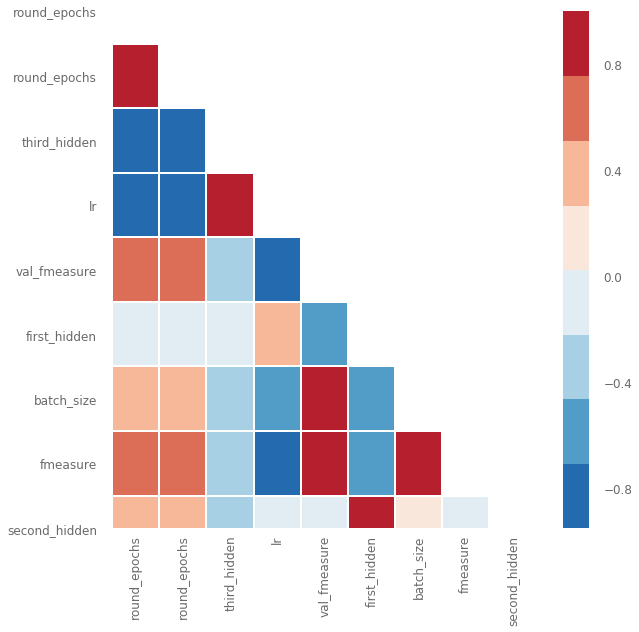

In [29]:
# heatmap correlation
analyze_object.plot_corr('val_fmeasure', ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

### Possiamo osservare come val_fmeasure sia direttamente proporzionale al numero di epoche e alla dimensione di batch. Inoltre è inversamente proporzionale alla dimensione del primo hidden layer, e al learning rate. Infine è circa neutro a quella del secondo e del terzo hidden.
### Cosa vuol dire? Beh, che è possibile ridurre lo spazio di ricerca andando a rimuovere dal dict le epoche minori, le batch minori, le dimensioni dei layer maggiori, e magari iniziare il LR Reducer con un learning rate più basso.

### Controlliamo però più nel dettaglio per farci un'idea anche dei range

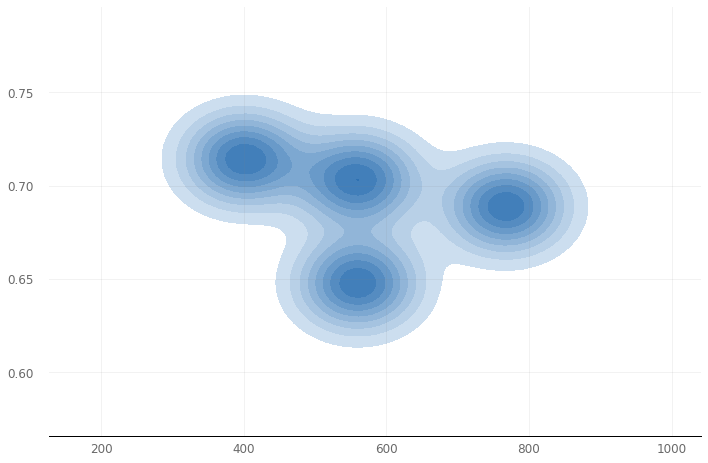

In [14]:
# Analyze the Kernel Density Estimator with validation fmeasure and the first hidden layer dimension
analyze_object.plot_kde('first_hidden', 'val_fmeasure')

# The first is x-axis, the second is y-axis

### Perfetto, come avevamo immaginato, possiamo osservare che i valori più alti di val f1 sono stati raggiunti con 400 neuroni nel primo hidden layer. 
### Controlliamo anche il batch size.

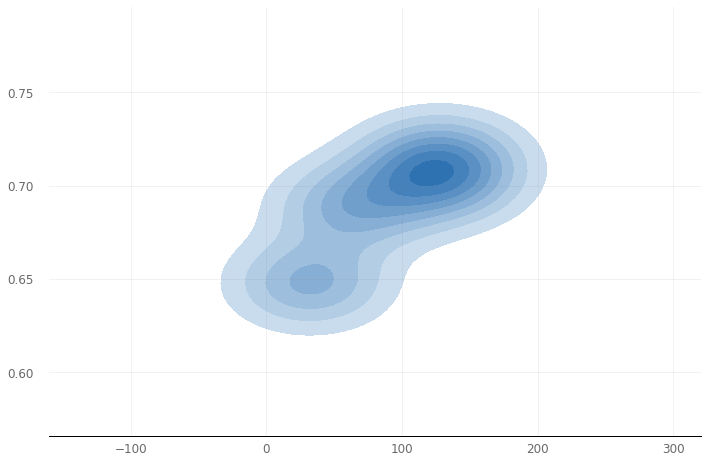

In [30]:
# Analyze the Kernel Density Estimator with validation fmeasure and the batch_size
analyze_object.plot_kde('batch_size', 'val_fmeasure')

### Benissimo, dovremmo preferire dimensioni superiori al 100: proveremo solo 128 e 256.

### Non ci è possibile controllare lo stesso grafico con il numero di epoche per via di un conflitto con una variabile pre-impostata chiamata round_epochs che abbiamo provato a sovrascrivere (nel plot della correlazione infatti compare due volte). Tuttavia, abbiamo visto come dobbiamo preferire numeri alti.

### Salviamoci il modello migliore in termini di validation fmeasure

In [18]:
talos.Deploy(scan_object=scan_object, model_name='toxic_comments_deploy', metric='val_fmeasure');

Deploy package toxic_comments_deploy have been saved.


In [19]:
model = talos.Restore('toxic_comments_deploy.zip')

### Ora possiamo testare grazie alla funzione model.predict

In [20]:
y_pred = np.round(model.model.predict(test_vectors))

In [21]:
c = classification_report(test_labels, y_pred, target_names=list_classes)
print(c)

               precision    recall  f1-score   support

        toxic       0.99      0.74      0.84      6090
 severe_toxic       0.42      0.29      0.34       367
      obscene       0.84      0.68      0.75      3691
       threat       0.75      0.35      0.48       211
       insult       0.80      0.61      0.69      3427
identity_hate       0.74      0.36      0.49       712

  avg / total       0.87      0.66      0.75     14498



### Già in dopo 4 scan random possiamo osservare un incremento notevole della micro average f1-score rispetto ai modelli precedentemente testati (base e data augmentation). Stampiamo per esteso il valore non arrotondato per avere una idea più precisa.

In [35]:
score = precision_recall_fscore_support(test_labels, y_pred, average='micro')
print('Micro avg: ', score)

Micro avg:  (0.8769500600018462, 0.6552627948682577, 0.7500690853104891, None)


### Adesso che abbiamo una idea più solida sui nostri iperparametri, possiamo andare a ridurre lo spazio di ricerca ridefinendo il dict

### Definiamo un ultima volta gli iperparametri e lanciamo la scan su più combinazioni

In [58]:
# Define AGAIN the params dict
params = {'first_hidden':[300, 400],
     'batch_size': [128, 256],
     'round_epochs': [18, 20],
     'second_hidden': [100, 200],
     'third_hidden': [32, 50]}

### Per questa analisi finale utilizziamo un budget maggiore, ovvero 16 iterazioni.

In [59]:
# Define AGAIN the scan, this time implement a probability reduction
scan_object = talos.Scan(x=x_train,
                         y=y_train,
                         x_val=x_val,
                         y_val=y_val,
                         params=params,
                         reduction_method='forrest',
                         reduction_metric='val_fmeasure',
                         performance_target=['val_fmeasure', 0.8, False],
                         model=toxic_clf,
                         fraction_limit= 0.5,
                         experiment_name='toxic_comments')


  0%|          | 0/16 [00:00<?, ?it/s]

Train on 127656 samples, validate on 31915 samples
Epoch 1/18
127656/127656 [==============================] - 6s 46us/step - loss: 0.0621 - accuracy: 0.9773 - fmeasure: 0.6173 - val_loss: 0.0554 - val_accuracy: 0.9792 - val_fmeasure: 0.6599
Epoch 2/18
127656/127656 [==============================] - 6s 46us/step - loss: 0.0555 - accuracy: 0.9794 - fmeasure: 0.6596 - val_loss: 0.0527 - val_accuracy: 0.9800 - val_fmeasure: 0.6762
Epoch 3/18
127656/127656 [==============================] - 6s 45us/step - loss: 0.0534 - accuracy: 0.9798 - fmeasure: 0.6710 - val_loss: 0.0529 - val_accuracy: 0.9802 - val_fmeasure: 0.6784
Epoch 4/18
127656/127656 [==============================] - 6s 45us/step - loss: 0.0519 - accuracy: 0.9802 - fmeasure: 0.6794 - val_loss: 0.0523 - val_accuracy: 0.9799 - val_fmeasure: 0.6710
Epoch 5/18
127656/127656 [==============================] - 6s 45us/step - loss: 0.0507 - accuracy: 0.9806 - fmeasure: 0.6883 - val_loss: 0.0515 - val_accuracy: 0.9803 - val_fmeasure: 0


  6%|▋         | 1/16 [01:45<26:25, 105.70s/it]


Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Train on 127656 samples, validate on 31915 samples
Epoch 1/18
127656/127656 [==============================] - 7s 59us/step - loss: 0.0617 - accuracy: 0.9772 - fmeasure: 0.6192 - val_loss: 0.0549 - val_accuracy: 0.9789 - val_fmeasure: 0.6367
Epoch 2/18
127656/127656 [==============================] - 7s 58us/step - loss: 0.0550 - accuracy: 0.9794 - fmeasure: 0.6629 - val_loss: 0.0528 - val_accuracy: 0.9798 - val_fmeasure: 0.6671
Epoch 3/18
127656/127656 [==============================] - 7s 56us/step - loss: 0.0530 - accuracy: 0.9801 - fmeasure: 0.6713 - val_loss: 0.0523 - val_accuracy: 0.9800 - val_fmeasure: 0.6646
Epoch 4/18
127656/127656 [==============================] - 7s 56us/step - loss: 0.0515 - accuracy: 0.9803 - fmeasure: 0.6798 - val_loss: 0.0507 - val_accuracy: 0.9807 - val_fmeasure: 0.6885
Epoch 5/18
127656/127656 [==============================] - 7s 56us/step - loss: 0.0507 - accuracy: 0.9


 12%|█▎        | 2/16 [03:54<26:17, 112.65s/it]


Epoch 00018: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 4s 33us/step - loss: 0.0629 - accuracy: 0.9768 - fmeasure: 0.6283 - val_loss: 0.0545 - val_accuracy: 0.9790 - val_fmeasure: 0.6510
Epoch 2/20
127656/127656 [==============================] - 4s 30us/step - loss: 0.0549 - accuracy: 0.9794 - fmeasure: 0.6686 - val_loss: 0.0536 - val_accuracy: 0.9793 - val_fmeasure: 0.6503
Epoch 3/20
127656/127656 [==============================] - 4s 30us/step - loss: 0.0525 - accuracy: 0.9800 - fmeasure: 0.6823 - val_loss: 0.0530 - val_accuracy: 0.9798 - val_fmeasure: 0.6997
Epoch 4/20
127656/127656 [==============================] - 4s 30us/step - loss: 0.0516 - accuracy: 0.9805 - fmeasure: 0.6917 - val_loss: 0.0513 - val_accuracy: 0.9803 - val_fmeasure: 0.6991
Epoch 5/20
127656/127656 [==============================] - 4s 30us/step - loss: 0.0503 - accuracy: 0.98


 19%|█▉        | 3/16 [05:13<22:12, 102.47s/it]


Epoch 00020: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 6s 46us/step - loss: 0.0634 - accuracy: 0.9765 - fmeasure: 0.6054 - val_loss: 0.0569 - val_accuracy: 0.9789 - val_fmeasure: 0.6481
Epoch 2/20
127656/127656 [==============================] - 6s 45us/step - loss: 0.0557 - accuracy: 0.9793 - fmeasure: 0.6587 - val_loss: 0.0532 - val_accuracy: 0.9796 - val_fmeasure: 0.6702
Epoch 3/20
127656/127656 [==============================] - 6s 45us/step - loss: 0.0533 - accuracy: 0.9799 - fmeasure: 0.6716 - val_loss: 0.0520 - val_accuracy: 0.9801 - val_fmeasure: 0.6857
Epoch 4/20
127656/127656 [==============================] - 6s 45us/step - loss: 0.0519 - accuracy: 0.9802 - fmeasure: 0.6795 - val_loss: 0.0522 - val_accuracy: 0.9802 - val_fmeasure: 0.6803
Epoch 5/20
127656/127656 [==============================] - 6s 45us/step - loss: 0.0511 - accuracy: 0.98


 25%|██▌       | 4/16 [07:10<21:21, 106.76s/it]

Train on 127656 samples, validate on 31915 samples
Epoch 1/18
127656/127656 [==============================] - 6s 44us/step - loss: 0.0620 - accuracy: 0.9773 - fmeasure: 0.6189 - val_loss: 0.0612 - val_accuracy: 0.9771 - val_fmeasure: 0.5696
Epoch 2/18
127656/127656 [==============================] - 5s 42us/step - loss: 0.0554 - accuracy: 0.9793 - fmeasure: 0.6582 - val_loss: 0.0530 - val_accuracy: 0.9796 - val_fmeasure: 0.6546
Epoch 3/18
127656/127656 [==============================] - 5s 43us/step - loss: 0.0528 - accuracy: 0.9800 - fmeasure: 0.6749 - val_loss: 0.0543 - val_accuracy: 0.9795 - val_fmeasure: 0.6596
Epoch 4/18
127656/127656 [==============================] - 5s 42us/step - loss: 0.0515 - accuracy: 0.9805 - fmeasure: 0.6863 - val_loss: 0.0520 - val_accuracy: 0.9801 - val_fmeasure: 0.6717
Epoch 5/18
127656/127656 [==============================] - 5s 42us/step - loss: 0.0504 - accuracy: 0.9807 - fmeasure: 0.6899 - val_loss: 0.0515 - val_accuracy: 0.9801 - val_fmeasure: 0


 31%|███▏      | 5/16 [08:48<19:06, 104.22s/it]

Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 6s 51us/step - loss: 0.0618 - accuracy: 0.9771 - fmeasure: 0.6206 - val_loss: 0.0555 - val_accuracy: 0.9792 - val_fmeasure: 0.6515
Epoch 2/20
127656/127656 [==============================] - 6s 50us/step - loss: 0.0548 - accuracy: 0.9795 - fmeasure: 0.6607 - val_loss: 0.0529 - val_accuracy: 0.9795 - val_fmeasure: 0.6723
Epoch 3/20
127656/127656 [==============================] - 6s 50us/step - loss: 0.0528 - accuracy: 0.9801 - fmeasure: 0.6770 - val_loss: 0.0516 - val_accuracy: 0.9802 - val_fmeasure: 0.6784
Epoch 4/20
127656/127656 [==============================] - 6s 50us/step - loss: 0.0516 - accuracy: 0.9805 - fmeasure: 0.6855 - val_loss: 0.0518 - val_accuracy: 0.9802 - val_fmeasure: 0.6724
Epoch 5/20
127656/127656 [==============================] - 6s 50us/step - loss: 0.0503 - accuracy: 0.9808 - fmeasure: 0.6909 - val_loss: 0.0511 - val_accuracy: 0.9807 - val_fmeasure: 0


 38%|███▊      | 6/16 [10:56<18:33, 111.37s/it]


Epoch 00020: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 6s 43us/step - loss: 0.0614 - accuracy: 0.9773 - fmeasure: 0.6268 - val_loss: 0.0554 - val_accuracy: 0.9790 - val_fmeasure: 0.6627
Epoch 2/20
127656/127656 [==============================] - 5s 42us/step - loss: 0.0550 - accuracy: 0.9793 - fmeasure: 0.6613 - val_loss: 0.0540 - val_accuracy: 0.9798 - val_fmeasure: 0.6789
Epoch 3/20
127656/127656 [==============================] - 5s 42us/step - loss: 0.0528 - accuracy: 0.9801 - fmeasure: 0.6765 - val_loss: 0.0537 - val_accuracy: 0.9793 - val_fmeasure: 0.6428
Epoch 4/20
127656/127656 [==============================] - 5s 43us/step - loss: 0.0512 - accuracy: 0.9805 - fmeasure: 0.6877 - val_loss: 0.0512 - val_accuracy: 0.9804 - val_fmeasure: 0.6788
Epoch 5/20
127656/127656 [==============================] - 6s 43us/step - loss: 0.0500 - accuracy: 0.9


 44%|████▍     | 7/16 [12:45<16:36, 110.74s/it]

Train on 127656 samples, validate on 31915 samples
Epoch 1/18
127656/127656 [==============================] - 6s 47us/step - loss: 0.0619 - accuracy: 0.9770 - fmeasure: 0.6224 - val_loss: 0.0554 - val_accuracy: 0.9789 - val_fmeasure: 0.6420
Epoch 2/18
127656/127656 [==============================] - 6s 46us/step - loss: 0.0550 - accuracy: 0.9794 - fmeasure: 0.6628 - val_loss: 0.0539 - val_accuracy: 0.9796 - val_fmeasure: 0.6877
Epoch 3/18
127656/127656 [==============================] - 6s 46us/step - loss: 0.0528 - accuracy: 0.9800 - fmeasure: 0.6748 - val_loss: 0.0531 - val_accuracy: 0.9799 - val_fmeasure: 0.6962
Epoch 4/18
127656/127656 [==============================] - 6s 46us/step - loss: 0.0519 - accuracy: 0.9803 - fmeasure: 0.6810 - val_loss: 0.0518 - val_accuracy: 0.9803 - val_fmeasure: 0.6873
Epoch 5/18
127656/127656 [==============================] - 6s 46us/step - loss: 0.0501 - accuracy: 0.9810 - fmeasure: 0.6947 - val_loss: 0.0515 - val_accuracy: 0.9802 - val_fmeasure: 0


 50%|█████     | 8/16 [14:31<14:33, 109.20s/it]

Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 6s 44us/step - loss: 0.0623 - accuracy: 0.9771 - fmeasure: 0.6258 - val_loss: 0.0556 - val_accuracy: 0.9785 - val_fmeasure: 0.6658
Epoch 2/20
127656/127656 [==============================] - 5s 43us/step - loss: 0.0556 - accuracy: 0.9791 - fmeasure: 0.6588 - val_loss: 0.0549 - val_accuracy: 0.9796 - val_fmeasure: 0.6491
Epoch 3/20
127656/127656 [==============================] - 5s 43us/step - loss: 0.0531 - accuracy: 0.9799 - fmeasure: 0.6743 - val_loss: 0.0520 - val_accuracy: 0.9802 - val_fmeasure: 0.6978
Epoch 4/20
127656/127656 [==============================] - 5s 43us/step - loss: 0.0516 - accuracy: 0.9805 - fmeasure: 0.6823 - val_loss: 0.0512 - val_accuracy: 0.9804 - val_fmeasure: 0.6898
Epoch 5/20
127656/127656 [==============================] - 5s 43us/step - loss: 0.0507 - accuracy: 0.9808 - fmeasure: 0.6878 - val_loss: 0.0517 - val_accuracy: 0.9805 - val_fmeasure: 0


 56%|█████▋    | 9/16 [16:22<12:48, 109.77s/it]


Epoch 00020: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Train on 127656 samples, validate on 31915 samples
Epoch 1/18
127656/127656 [==============================] - 4s 32us/step - loss: 0.0637 - accuracy: 0.9762 - fmeasure: 0.6256 - val_loss: 0.0548 - val_accuracy: 0.9789 - val_fmeasure: 0.6788
Epoch 2/18
127656/127656 [==============================] - 4s 31us/step - loss: 0.0547 - accuracy: 0.9794 - fmeasure: 0.6696 - val_loss: 0.0565 - val_accuracy: 0.9792 - val_fmeasure: 0.6372
Epoch 3/18
127656/127656 [==============================] - 4s 31us/step - loss: 0.0529 - accuracy: 0.9801 - fmeasure: 0.6828 - val_loss: 0.0534 - val_accuracy: 0.9797 - val_fmeasure: 0.7026
Epoch 4/18
127656/127656 [==============================] - 4s 31us/step - loss: 0.0513 - accuracy: 0.9806 - fmeasure: 0.6928 - val_loss: 0.0530 - val_accuracy: 0.9798 - val_fmeasure: 0.6619
Epoch 5/18
127656/127656 [==============================] - 4s 31us/step - loss: 0.0505 - accuracy: 0.98


 62%|██████▎   | 10/16 [17:35<09:53, 98.84s/it]


Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 7s 57us/step - loss: 0.0622 - accuracy: 0.9772 - fmeasure: 0.6256 - val_loss: 0.0549 - val_accuracy: 0.9792 - val_fmeasure: 0.6458
Epoch 2/20
127656/127656 [==============================] - 7s 57us/step - loss: 0.0552 - accuracy: 0.9794 - fmeasure: 0.6617 - val_loss: 0.0530 - val_accuracy: 0.9800 - val_fmeasure: 0.6711
Epoch 3/20
127656/127656 [==============================] - 8s 59us/step - loss: 0.0530 - accuracy: 0.9800 - fmeasure: 0.6779 - val_loss: 0.0527 - val_accuracy: 0.9801 - val_fmeasure: 0.6833
Epoch 4/20
127656/127656 [==============================] - 7s 56us/step - loss: 0.0518 - accuracy: 0.9804 - fmeasure: 0.6809 - val_loss: 0.0519 - val_accuracy: 0.9801 - val_fmeasure: 0.6696
Epoch 5/20
127656/127656 [==============================] - 7s 57us/step - loss: 0.0504 - accuracy: 0.9


 69%|██████▉   | 11/16 [19:59<09:21, 112.24s/it]

Train on 127656 samples, validate on 31915 samples
Epoch 1/18
127656/127656 [==============================] - 4s 31us/step - loss: 0.0627 - accuracy: 0.9771 - fmeasure: 0.6339 - val_loss: 0.0618 - val_accuracy: 0.9765 - val_fmeasure: 0.5536
Epoch 2/18
127656/127656 [==============================] - 4s 30us/step - loss: 0.0549 - accuracy: 0.9795 - fmeasure: 0.6707 - val_loss: 0.0548 - val_accuracy: 0.9796 - val_fmeasure: 0.6700
Epoch 3/18
127656/127656 [==============================] - 4s 30us/step - loss: 0.0529 - accuracy: 0.9800 - fmeasure: 0.6813 - val_loss: 0.0534 - val_accuracy: 0.9797 - val_fmeasure: 0.6681
Epoch 4/18
127656/127656 [==============================] - 4s 30us/step - loss: 0.0515 - accuracy: 0.9805 - fmeasure: 0.6924 - val_loss: 0.0562 - val_accuracy: 0.9790 - val_fmeasure: 0.6287
Epoch 5/18
127656/127656 [==============================] - 4s 30us/step - loss: 0.0506 - accuracy: 0.9806 - fmeasure: 0.6944 - val_loss: 0.0505 - val_accuracy: 0.9806 - val_fmeasure: 0


 75%|███████▌  | 12/16 [21:09<06:38, 99.62s/it] 


Epoch 00018: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Train on 127656 samples, validate on 31915 samples
Epoch 1/18
127656/127656 [==============================] - 5s 36us/step - loss: 0.0626 - accuracy: 0.9770 - fmeasure: 0.6318 - val_loss: 0.0554 - val_accuracy: 0.9783 - val_fmeasure: 0.6308
Epoch 2/18
127656/127656 [==============================] - 5s 35us/step - loss: 0.0543 - accuracy: 0.9794 - fmeasure: 0.6713 - val_loss: 0.0531 - val_accuracy: 0.9796 - val_fmeasure: 0.6876
Epoch 3/18
127656/127656 [==============================] - 5s 36us/step - loss: 0.0524 - accuracy: 0.9801 - fmeasure: 0.6847 - val_loss: 0.0521 - val_accuracy: 0.9803 - val_fmeasure: 0.6789
Epoch 4/18
127656/127656 [==============================] - 5s 36us/step - loss: 0.0514 - accuracy: 0.9804 - fmeasure: 0.6936 - val_loss: 0.0538 - val_accuracy: 0.9797 - val_fmeasure: 0.7016
Epoch 5/18
127656/127656 [==============================] - 5s 37us/step - loss: 0.0498 - accuracy: 0.98


 81%|████████▏ | 13/16 [22:33<04:44, 94.90s/it]


Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 5s 37us/step - loss: 0.0625 - accuracy: 0.9772 - fmeasure: 0.6282 - val_loss: 0.0563 - val_accuracy: 0.9784 - val_fmeasure: 0.6231
Epoch 2/20
127656/127656 [==============================] - 5s 36us/step - loss: 0.0544 - accuracy: 0.9795 - fmeasure: 0.6718 - val_loss: 0.0545 - val_accuracy: 0.9793 - val_fmeasure: 0.6484
Epoch 3/20
127656/127656 [==============================] - 5s 36us/step - loss: 0.0527 - accuracy: 0.9802 - fmeasure: 0.6873 - val_loss: 0.0560 - val_accuracy: 0.9788 - val_fmeasure: 0.6319
Epoch 4/20
127656/127656 [==============================] - 5s 36us/step - loss: 0.0511 - accuracy: 0.9807 - fmeasure: 0.6950 - val_loss: 0.0525 - val_accuracy: 0.9800 - val_fmeasure: 0.6687
Epoch 5/20
127656/127656 [==============================] - 5s 36us/step - loss: 0.0501 - accuracy: 0.9


 88%|████████▊ | 14/16 [24:06<03:08, 94.39s/it]


Epoch 00020: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 4s 35us/step - loss: 0.0632 - accuracy: 0.9766 - fmeasure: 0.6259 - val_loss: 0.0556 - val_accuracy: 0.9791 - val_fmeasure: 0.6940
Epoch 2/20
127656/127656 [==============================] - 4s 33us/step - loss: 0.0542 - accuracy: 0.9796 - fmeasure: 0.6739 - val_loss: 0.0526 - val_accuracy: 0.9799 - val_fmeasure: 0.6641
Epoch 3/20
127656/127656 [==============================] - 4s 34us/step - loss: 0.0523 - accuracy: 0.9801 - fmeasure: 0.6860 - val_loss: 0.0515 - val_accuracy: 0.9804 - val_fmeasure: 0.6902
Epoch 4/20
127656/127656 [==============================] - 4s 33us/step - loss: 0.0510 - accuracy: 0.9805 - fmeasure: 0.6925 - val_loss: 0.0505 - val_accuracy: 0.9804 - val_fmeasure: 0.6927
Epoch 5/20
127656/127656 [==============================] - 4s 34us/step - loss: 0.0496 - accuracy: 0.98


 94%|█████████▍| 15/16 [25:33<01:32, 92.06s/it]

Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 4s 35us/step - loss: 0.0626 - accuracy: 0.9765 - fmeasure: 0.6266 - val_loss: 0.0589 - val_accuracy: 0.9782 - val_fmeasure: 0.6942
Epoch 2/20
127656/127656 [==============================] - 4s 33us/step - loss: 0.0541 - accuracy: 0.9796 - fmeasure: 0.6741 - val_loss: 0.0520 - val_accuracy: 0.9802 - val_fmeasure: 0.6878
Epoch 3/20
127656/127656 [==============================] - 4s 33us/step - loss: 0.0522 - accuracy: 0.9801 - fmeasure: 0.6860 - val_loss: 0.0518 - val_accuracy: 0.9800 - val_fmeasure: 0.6766
Epoch 4/20
127656/127656 [==============================] - 4s 33us/step - loss: 0.0506 - accuracy: 0.9807 - fmeasure: 0.6969 - val_loss: 0.0511 - val_accuracy: 0.9803 - val_fmeasure: 0.6979
Epoch 5/20
127656/127656 [==============================] - 4s 33us/step - loss: 0.0496 - accuracy: 0.9811 - fmeasure: 0.7041 - val_loss: 0.0509 - val_accuracy: 0.9805 - val_fmeasure: 0


100%|██████████| 16/16 [26:59<00:00, 101.21s/it][A


### Testiamo ancora

In [60]:
talos.Deploy(scan_object=scan_object, model_name='toxic_comments_deploy_last', metric='val_fmeasure');

model = talos.Restore('toxic_comments_deploy_last.zip')

Deploy package toxic_comments_deploy_last have been saved.


In [61]:
y_pred = np.round(model.model.predict(test_vectors))
c = classification_report(test_labels, y_pred, target_names=list_classes)
print(c)

score = precision_recall_fscore_support(test_labels, y_pred, average='micro')
print('Micro avg: ', score)

               precision    recall  f1-score   support

        toxic       0.99      0.74      0.85      6090
 severe_toxic       0.41      0.27      0.32       367
      obscene       0.84      0.67      0.74      3691
       threat       0.76      0.36      0.49       211
       insult       0.79      0.62      0.69      3427
identity_hate       0.75      0.32      0.45       712

  avg / total       0.87      0.66      0.75     14498

Micro avg:  (0.8769570823356051, 0.6567802455511105, 0.7510648367250355, None)


### Proprio quello che volevamo! abbiamo trovato una combinazione che ci ha permesso di superare il 75% di fmeasure in micro avg.

### Controlliamo ora gli iperparametri

In [63]:
bp = analyze_object.best_params('val_fmeasure', exclude=['val_loss', 'val_accuracy', 'loss', 
                                                         'accuracy','fmeasure', 'lr'])
print("Best params: ")
print("Number of epochs: ",bp[0][1])
print("Batch size: ", bp[0][4])
print("Third hidden: ", bp[0][2])
print("Second hidden: ", bp[0][5])
print("First hidden: ", bp[0][3])

Best params: 
Number of epochs:  15
Batch size:  256
Third hidden:  50
Second hidden:  200
First hidden:  500


### Osserviamo infine l'andamento del best seen per quanto riguarda Fmeasure e Val Fmeasure

In [73]:
def plot_best_seen(best_seen, iteration, measure):
    plt.figure()
    plt.xlabel('Iteration')
    plt.ylabel(measure)
    plt.step(iteration, best_seen)
    plt.ylim(best_seen[0]-0.002, best_seen[len(best_seen)-1]+0.002)
    plt.xticks(np.arange(0, len(iteration)+1, 1)) 
    plt.show()

def create_bestseen(values):
    best_seen = []
    iteration = []
    i = 0

    for val in values:
        if (i == 0): best_seen.append(val)
        elif (val > best_seen[i-1]): best_seen.append(val)
        else: best_seen.append(best_seen[i-1])
        i += 1
        iteration.append(i)

    return best_seen, iteration

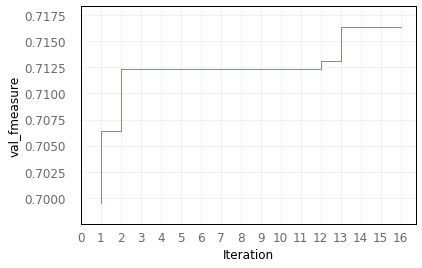

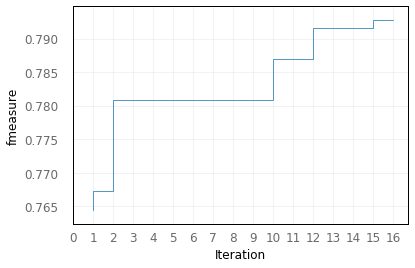

In [75]:
PATH = path.abspath("")+'/toxic_comments_deploy_last/'

df = pd.read_csv(PATH+'toxic_comments_deploy_last_results.csv')

val_fmeasure = df['val_fmeasure']
fmeasure = df['fmeasure']

best_seen_valf, iteration_valf = create_bestseen(val_fmeasure)
best_seen_f, iteration_f = create_bestseen(fmeasure)

plot_best_seen(best_seen_valf, iteration_valf, 'val_fmeasure')
plot_best_seen(best_seen_f, iteration_f, 'fmeasure')

### Osserviamo alcuni errori: in posizione 101 ad esempio il commento non è stato classificato come insult

In [84]:
print("Real labels: ",test_labels.values[101])
print("Prediction: ",y_pred[101])

Real labels:  [1. 0. 0. 0. 1. 0.]
Prediction:  [1. 0. 0. 0. 0. 0.]


### Controlliamo il commento originale per capirne di più

In [97]:
test_data = pd.read_csv('dataset/test.csv')
temp_test_labels = pd.read_csv('dataset/test_labels.csv')
test_combined = pd.merge(test_data, temp_test_labels, on=['id'])

# Now remove -1 and 0 values
test_data = test_combined[(test_combined.toxic == 1) | (test_combined.severe_toxic == 1) |
                      (test_combined.obscene == 1) | (test_combined.threat == 1) | (test_combined.insult == 1) |
                      (test_combined.identity_hate == 1)]

In [103]:
comments = test_data.comment_text.values
print(comments[101])

I sometimes wonder why some people feel they are entitled to act any way they want, I was not bothering you, and yet you have started this.  I don't think it is any of your concern what I do...who are you to police me??  Like your so innocent, You are constantly stirring up the pot and causing trouble, so save me your so innocent act and quit being a hypocrite....wanna be revolutionary, you think your so perfect and righteous and everyone is wrong except you...your a biased fanatic and you make me sick, your a spoiled baby and I want you to quit interfering in what I do!!


### Ok, questo commento è abbastanza ambiguo, ci può stare un errore su questo, anche perchè osservandolo non sembrerebbe nemmeno un insulto ma un commento in risposta a qualcuno che ha effettivamente insultato.

### Osserviamone un altro, il 108 è stato interamente sbagliato:

In [104]:
print("Real labels: ",test_labels.values[108])
print("Prediction: ",y_pred[108])

Real labels:  [1. 0. 0. 0. 1. 1.]
Prediction:  [0. 0. 0. 0. 0. 0.]


In [105]:
print(comments[108])

Look, you're a pedant, and Fetzer is a Jew-hater. On Press TV in the UK today - September 2nd 2011 - he said that the Israelis were behind 9/11. The man is a complete fool.


### Anche in questo caso probabilmente c'è un errore nella etichettatura. A tal proposito, alcune veloci considerazioni possono essere che, se è stata una macchina ad etichettare, allora probabilmente vi era un bias verso alcune parole (jew -> identity hate), altrimenti se è stato un umano allora ha proprio sbagliato. Ci sta etichettare questo commento come tossico, alla fine sta criticando/insultando qualcuno, ma etichettarlo come identity hate è eccessivo.

### Osserviamo ora il 104

In [106]:
print("Real labels: ",test_labels.values[104])
print("Prediction: ",y_pred[104])

Real labels:  [1. 0. 1. 0. 0. 0.]
Prediction:  [0. 0. 0. 0. 0. 0.]


In [107]:
print(comments[104])

== CHANGES TO DUARTE ARE TRUE == 

 Wikipedia sucks.


### In questo caso, l'etichetta oscena sembra eccessiva. "wikipedia fa schifo" ci sta come commento tossico, ma non osceno.

### Osserviamo ora un caso diverso, ovvero una situazione in cui il nostro classificatore ha etichettato commenti che non andavano etichettati:

In [108]:
print("Real labels: ",test_labels.values[105])
print("Prediction: ",y_pred[105])

Real labels:  [1. 0. 0. 0. 1. 0.]
Prediction:  [1. 1. 1. 0. 1. 0.]


In [109]:
print(comments[105])

sup my peeps japan sucks hola from mexico senioritas you suuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuucccccccccccccccccccccccccccccccccckkkkkkkkkkkkkkk


### Questo commento pare molto più osceno rispetto al commento precedente. Probabilmente tutte queste lettere in aggiunta hanno enfatizzato la tossicità nel nostro classificatore.

### Osserviamo il numero 2000

In [115]:
print("Real labels: ",test_labels.values[2000])
print("Prediction: ",y_pred[2000])

Real labels:  [1. 0. 1. 0. 1. 0.]
Prediction:  [1. 0. 0. 0. 1. 0.]


In [116]:
print(comments[2000])

:You're a so stupid guy.


### Anche in questo caso, il tag obscene sembra eccessivo. E' un commento tossico relativo a un insulto, il nostro classificatore ha classificato bene.

### Osserviamo un ultimo commento

In [121]:
print("Real labels: ",test_labels.values[2016])
print("Prediction: ",y_pred[2016])

Real labels:  [1. 0. 1. 0. 1. 0.]
Prediction:  [0. 0. 0. 0. 0. 0.]


In [122]:
print(comments[2016])

" 
 :Yeah, wouldn't that be fun if we'd just let you put your junk wherever it pleases you; as for the ""clown""-label, read WP:NPA.   "


### Questo è un altro commento estremamente ambiguo, difficile da interpretare perfino per un umano.

### Concludendo, è evidente che molte etichette siano state utilizzate male/a sproposito, quindi ci aspettiamo che il nostro classificatore funzioni in realtà meglio di quanto visto nel classification report.